In [1]:
import numpy as np
import matplotlib.pyplot as plt;
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K



/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#load images
x_train=np.load("small_56x56_celebs_300.npy")

In [3]:
#normalizae images
def normalize_images(x):
    d=(x.astype(np.float64)/255)
    return d

#segment images into validation, testing, and training
numtest=50
x_test=normalize_images(x_train[-numtest/2:-1,:,:,0:1])
x_true_test=normalize_images(x_train[-numtest:-numtest/2,:,:,0:1])
x_train=normalize_images(x_train[0:-numtest/2,:,:,0:1])

#make noisy images
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_true_test_noisy=x_true_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_true_test.shape)

#clip noisy images so they don't increase past 0 or 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0, 1.)
x_true_test_noisy = np.clip(x_true_test_noisy, 0, 1.)


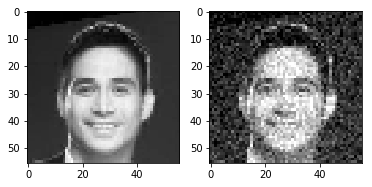

In [4]:
#show sample
which=np.random.randint(len(x_test))
ax = plt.subplot(1, 2, 1)
plt.imshow(x_train[which,:,:,0])
plt.gray()
ax = plt.subplot(1, 2, 2)
plt.imshow(x_train_noisy[which,:,:,0])
plt.gray()

In [5]:
#Build NN structure
optimizer2use=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)



#encoder
input_img = Input(shape=(56, 56, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


In [6]:
#run training
numepochs=50
numBS=100
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer2use, loss='mean_squared_error')
history=autoencoder.fit(x_train_noisy, x_train,
                epochs=numepochs,
                batch_size=numBS,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
np.save("ADAM+MSE_history_epoch"+str(10)+"_BS"+str(numBS)+".npy", autoencoder.history.history)


Train on 276 samples, validate on 24 samples
Epoch 1/50
276/276 [==============================] - 2s 8ms/step - loss: 0.0888 - val_loss: 0.0910
Epoch 2/50
276/276 [==============================] - 0s 559us/step - loss: 0.0822 - val_loss: 0.0764
Epoch 3/50
276/276 [==============================] - 0s 547us/step - loss: 0.0627 - val_loss: 0.0634
Epoch 4/50
276/276 [==============================] - 0s 522us/step - loss: 0.0578 - val_loss: 0.0402
Epoch 5/50
276/276 [==============================] - 0s 540us/step - loss: 0.0334 - val_loss: 0.0264
Epoch 6/50
276/276 [==============================] - 0s 539us/step - loss: 0.0270 - val_loss: 0.0289
Epoch 7/50
276/276 [==============================] - 0s 535us/step - loss: 0.0438 - val_loss: 0.0277
Epoch 8/50
276/276 [==============================] - 0s 535us/step - loss: 0.0270 - val_loss: 0.0237
Epoch 9/50
276/276 [==============================] - 0s 540us/step - loss: 0.0240 - val_loss: 0.0235
Epoch 10/50
276/276 [==================

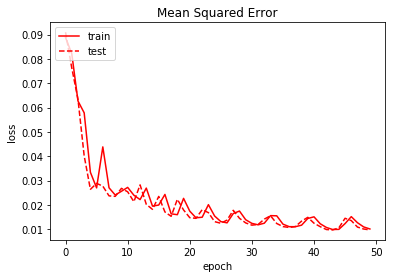

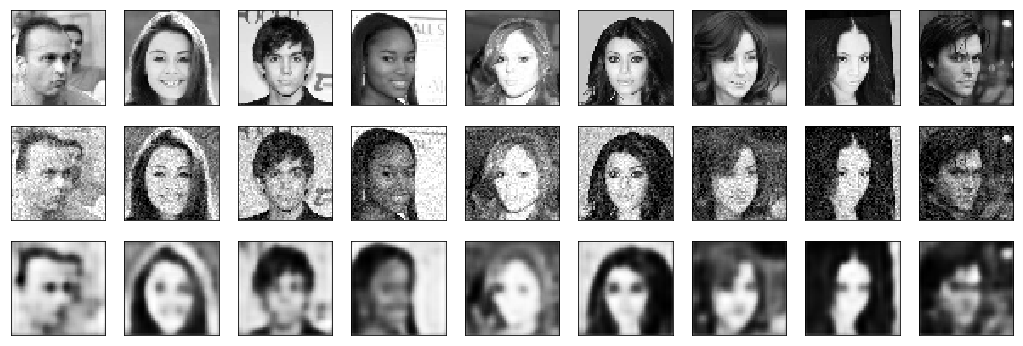

0.06805490222658511


In [11]:
plt.plot(history.history['loss'],c='r')
plt.plot(history.history['val_loss'],'r--')
plt.title('Mean Squared Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

decoded_imgs = autoencoder.predict(x_true_test_noisy)
which=np.linspace(6,15,10)
n = 10
plt.figure(figsize=(20, 6))
for i in range(1,n):
    
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_true_test[[i+1]].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_true_test_noisy[i+1].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i+1].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
measure=np.mean(abs(decoded_imgs-x_true_test))
print(measure)